**Importing Library and Installing Packages**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


**Download Dataset using kaggle**

In [3]:
# Get kaggle.json from kaggle by Create New API Token 
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download techsash/waste-classification-data

Saving kaggle.json to kaggle.json
 98% 418M/427M [00:03<00:00, 131MB/s]
100% 427M/427M [00:03<00:00, 126MB/s]


**Load Dataset and Saving images**

In [4]:
path = os.getcwd()

data = path + '/waste-classification-data.zip'
zip_ref = zipfile.ZipFile(data, 'r')
zip_ref.extractall(path)

zip_ref.close()

os.listdir()

train_dir = path + '/DATASET/TRAIN'
validation_dir = path + '/DATASET/TEST'

train_organic_dir = os.path.join(train_dir, 'O')
train_anorganic_dir = os.path.join(train_dir, 'R')

validation_organic_dir = os.path.join(validation_dir, 'O')
validation_anorganic_dir = os.path.join(validation_dir, 'R')

**Training and Validation Generators**

In [5]:
def train_val_generators(train_dir, validation_dir):

  train_datagen = ImageDataGenerator(rescale=1/255)
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  
  validation_datagen = ImageDataGenerator(rescale=1/255)

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


**Model** (Result 92%)

In [6]:
model = tf.keras.Sequential([
    # Input_shape = (150, 150, 3)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu' ,input_shape=(150, 150, 3)),
    # Pool_size = (2,2)
    tf.keras.layers.MaxPooling2D(2, 2),
     
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),

    # Output arrays of size 64
    tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(28, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
      
    # Using activation sigmoid for 2 clases
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Optimizer using default value
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name = 'accuracy')])

**Callbacks** (Optional)

In [7]:
class myCallback(tf.keras.callbacks.Callback):
           
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy')) > 0.99: 
                print("\nReached 99% accuracy so cancelling training!")    
                self.model.stop_training = True

# Initiate callbacks
callbacks = myCallback()

**Training**

In [8]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=callbacks) 

Epoch 1/10
353/353 [==============================] - 332s 936ms/step - loss: 0.4755 - accuracy: 0.8571 - val_loss: 0.4824 - val_accuracy: 0.9281
Epoch 2/10
353/353 [==============================] - 326s 922ms/step - loss: 0.4109 - accuracy: 0.8952 - val_loss: 0.3890 - val_accuracy: 0.9346
Epoch 3/10
353/353 [==============================] - 320s 905ms/step - loss: 0.3545 - accuracy: 0.9227 - val_loss: 0.4898 - val_accuracy: 0.9379
Epoch 4/10
353/353 [==============================] - 320s 907ms/step - loss: 0.2916 - accuracy: 0.9473 - val_loss: 0.2875 - val_accuracy: 0.9535
Epoch 5/10
353/353 [==============================] - 320s 906ms/step - loss: 0.2208 - accuracy: 0.9694 - val_loss: 0.3386 - val_accuracy: 0.9383
Epoch 6/10
353/353 [==============================] - 321s 909ms/step - loss: 0.1703 - accuracy: 0.9815 - val_loss: 0.3791 - val_accuracy: 0.9271
Epoch 7/10
353/353 [==============================] - 319s 904ms/step - loss: 0.1293 - accuracy: 0.9888 - val_loss: 0.4231 -

**CNN Model Baseline**

In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                          

Convert to **Tflite** and **h5** (Optional)

In [10]:
export_dir = 'saved_model/1'

tf.saved_model.save(model,export_dir=export_dir)

# Mode of optimization
mode = "Default" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

# Converting to h5 model
tf.keras.models.save_model(model, "./model.h5")

INFO:tensorflow:Assets written to: saved_model/1/assets


0.06345 % non organic
99.93655 % organic


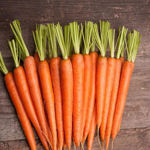